# Day 3: TRB Index Bias vs. Lead Time

This notebook creates a plot for each observation source (GPCC, CHIRPS, MSWEP) showing the TRB index bias for each lead time for each DCPP model. The TRB index bias was calculated by subtracting the observation-derived index from the DCPP model-derived index. The same six panel format is used and explained in 00_DCPP_GPCC_visualisation.ipynb.

CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1
CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1
CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1


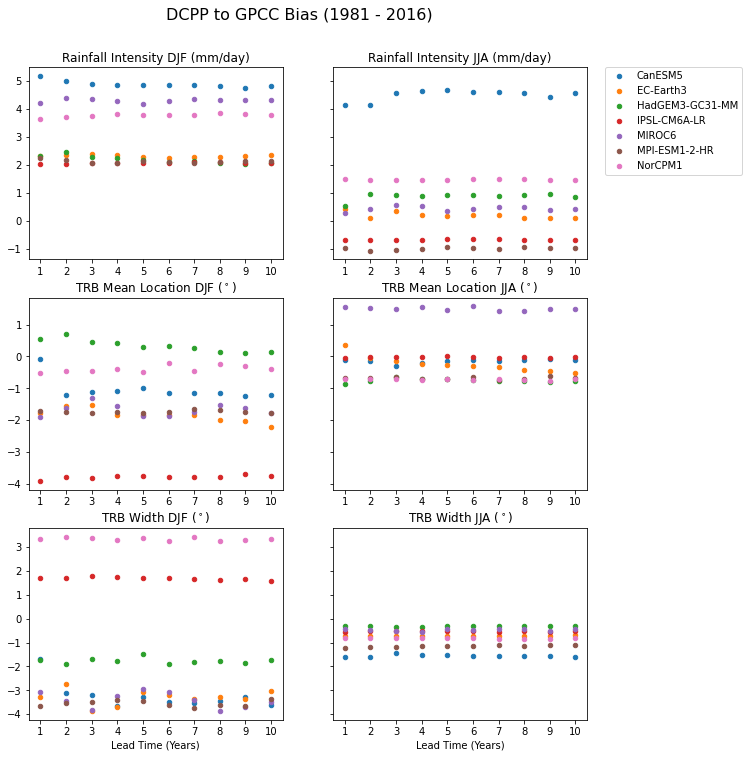

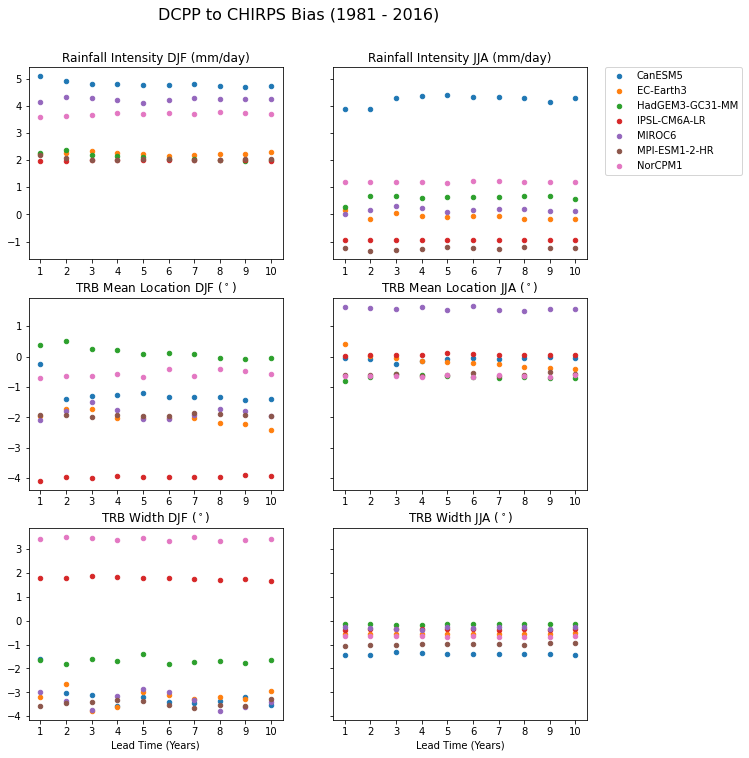

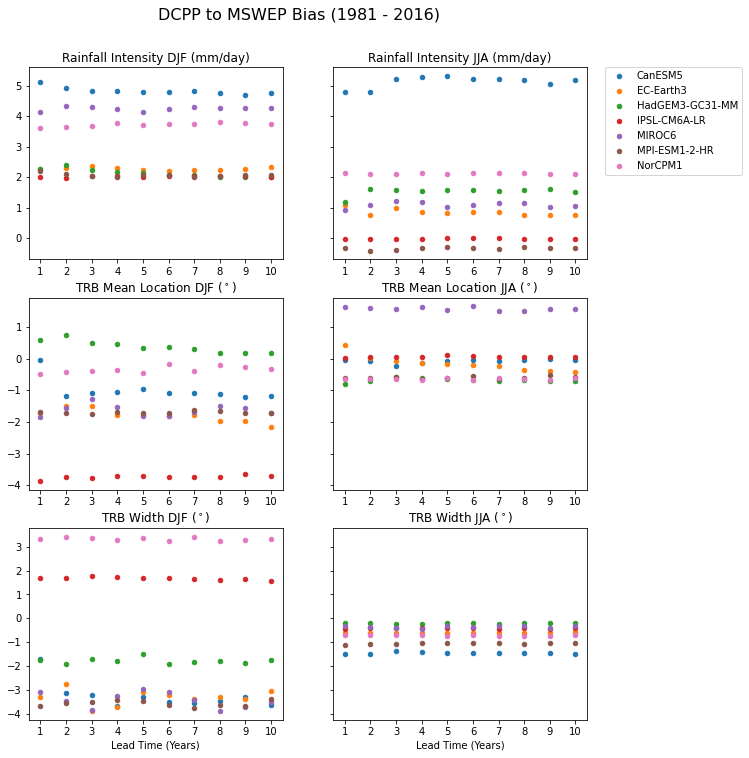

In [10]:
import numpy as np
import xarray as xr
import glob as glob
import matplotlib.pyplot as plt
from scipy.stats import t

model_namelist = ['CanESM5', 'EC-Earth3', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'NorCPM1']
obs_namelist = ['GPCC', 'CHIRPS', 'MSWEP']
dcpp_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/DCPP/TRBindices'
obs_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/obs/TRBindices'

for obs_name in obs_namelist:

    fig, axs = plt.subplots(3, 2, figsize=(10,12), sharey='row')
    lead_time_years = np.arange(1,11,1)

    obs_filelist = glob.glob(obs_trbindices_directory+'/'+obs_name+'/*.nc')
    obs_filelist.sort()

    # Selection conditions
    obs_data = xr.open_mfdataset(obs_filelist)
    obs_data_indices = obs_data.gaussian_params
    is_djf = (obs_data_indices['time'].dt.season == 'DJF')
    is_jja = (obs_data_indices['time'].dt.season == 'JJA')
    obs_data_djf = obs_data_indices.isel(time=is_djf)
    obs_data_jja = obs_data_indices.isel(time=is_jja)

    obs_data_mean_djf = obs_data_djf.groupby('time.year').mean('time')
    obs_data_mean_djf_1981_2016 = obs_data_mean_djf.sel(year=slice(1981,2016))

    obs_data_mean_jja = obs_data_jja.groupby('time.year').mean('time')
    obs_data_mean_jja_1981_2016 = obs_data_mean_jja.sel(year=slice(1981,2016))

    for model_name in model_namelist:
        print(model_name)

        model_filelist = glob.glob(dcpp_trbindices_directory+'/'+model_name+'/*.nc')
        model_filelist.sort()

        bias_list_djf = list()
        bias_list_jja = list()
        for lead_time_year in lead_time_years:
            model_ensembles_all_djf = list()
            model_ensembles_all_jja = list()

            # Combining all forecasts
            for model_file in model_filelist:
                model_dataset = xr.open_dataset(model_file)

                # Selection conditions
                is_djf = (model_dataset['time'].dt.season == 'DJF')
                is_jja = (model_dataset['time'].dt.season == 'JJA')


                model_ensemble_mean = model_dataset.gaussian_params.mean(dim='ensemble')
                model_ensemble_mean_djf = model_ensemble_mean.isel(time=is_djf)
                model_ensemble_mean_djf = model_ensemble_mean_djf.groupby('time.year').mean('time').isel(year=lead_time_year-1)
                model_ensembles_all_djf.append(model_ensemble_mean_djf)

                model_ensemble_mean_jja = model_ensemble_mean.isel(time=is_jja)
                model_ensemble_mean_jja = model_ensemble_mean_jja.groupby('time.year').mean('time').isel(year=lead_time_year-1)
                model_ensembles_all_jja.append(model_ensemble_mean_jja)

            # Calculate model bias (model minus obs)
            lead_time_time_series_djf = xr.concat(model_ensembles_all_djf, dim='year').sel(year=slice(1981,2016))
            lead_time_time_series_djf_bias = (lead_time_time_series_djf - obs_data_mean_djf_1981_2016).mean(dim='year')

            lead_time_time_series_jja = xr.concat(model_ensembles_all_jja, dim='year').sel(year=slice(1981,2016))
            lead_time_time_series_jja_bias = (lead_time_time_series_jja - obs_data_mean_jja_1981_2016).mean(dim='year')

            bias_list_djf.append(lead_time_time_series_djf_bias)
            bias_list_jja.append(lead_time_time_series_jja_bias)

        this_model_bias_djf = xr.concat(bias_list_djf, dim='lead_time')
        this_model_bias_jja = xr.concat(bias_list_jja, dim='lead_time')

        axs[0,0].scatter(lead_time_years, this_model_bias_djf[:,0], label=model_name, s=20.0)
        axs[1,0].scatter(lead_time_years, this_model_bias_djf[:,1], label=model_name, s=20.0)
        axs[2,0].scatter(lead_time_years, this_model_bias_djf[:,2], label=model_name, s=20.0)
        axs[0,1].scatter(lead_time_years, this_model_bias_jja[:,0], label=model_name, s=20.0)
        axs[1,1].scatter(lead_time_years, this_model_bias_jja[:,1], label=model_name, s=20.0)
        axs[2,1].scatter(lead_time_years, this_model_bias_jja[:,2], label=model_name, s=20.0)

    axs[0,1].legend(bbox_to_anchor=(1.05, 1.03), loc='upper left')
    axs[0,0].set_title('Rainfall Intensity DJF (mm/day)')
    axs[0,0].set_xticks(lead_time_years)
    axs[1,0].set_title(r'TRB Mean Location DJF ($^\circ$)')
    axs[1,0].set_xticks(lead_time_years)
    axs[2,0].set_title(r'TRB Width DJF ($^\circ$)')
    axs[2,0].set_xticks(lead_time_years)
    axs[2,0].set_xlabel('Lead Time (Years)')
    axs[0,1].set_title('Rainfall Intensity JJA (mm/day)')
    axs[0,1].set_xticks(lead_time_years)
    axs[1,1].set_title(r'TRB Mean Location JJA ($^\circ$)')
    axs[1,1].set_xticks(lead_time_years)
    axs[2,1].set_title(r'TRB Width JJA ($^\circ$)')
    axs[2,1].set_xlabel('Lead Time (Years)')
    axs[2,1].set_xticks(lead_time_years)

    fig.suptitle(f"DCPP to {obs_name} Bias (1981 - 2016)", fontsize=16, y=0.95)

    # plt.show()
    plt.savefig(f'plots/bias_analysis/bias_DCPP_to_{obs_name}.pdf', bbox_inches='tight')